#**Homework 2 - Classification**
若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

Optimize the Logisit Regression Model using

1. Initialize weight using uniform random method

2. Implement adagrad so that weight decay as epoh increase

3. Implement L2 regulization


Result: 

Private Score: 0.89059

Public Score: 0.88914
![替代文字](https://drive.google.com/uc?id=1h3NnRiUkG7Nve7klqFEnGt8qepvuTsM9)

Ranked: 116/285

![替代文字](https://drive.google.com/uc?id=11X3JMLedDaWoaCR1SZX6eC4aTp9TNZ1v)

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

#Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

這個資料集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 經過一些處理而得來。為了方便訓練，我們移除了一些不必要的資訊，並且稍微平衡了正負兩種標記的比例。事實上在訓練過程中，只有 X_train、Y_train 和 X_test 這三個經過處理的檔案會被使用到，train.csv 和 test.csv 這兩個原始資料檔則可以提供你一些額外的資訊。

In [1]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz
!ls

Downloading...
From: https://drive.google.com/uc?id=1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92
To: /content/data.tar.gz
6.11MB [00:00, 28.4MB/s]
data/
data/sample_submission.csv
data/test_no_label.csv
data/train.csv
data/X_test
data/X_train
data/Y_train
data  data.tar.gz  sample_data


#Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我們會實作 logistic regression，針對理論細節說明請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=hSXFuypLukA)

###Preparing Data

Load and normalize data, and then split training data into training set and development set.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [87]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

def _train_dev_split_inverse(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[train_size:], Y[train_size:], X[:train_size], Y[:train_size]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.0
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 54256
Size of development set: 0
Size of testing set: 27622
Dimension of data: 510



###Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

In [3]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)

def _predict_prob(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return _f(X, w, b)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。

In [4]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


### Training

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

Optimize the Logisit Regression Model using

1. Initialize weight using uniform random method

2. Implement adagrad so that weight decay as epoh increase

3. Implement L2 regulization


In [88]:
from tqdm.notebook import trange
#use uniform random to initialize weights
w = np.random.uniform(0.01, -0.01, data_dim)
b = np.zeros((1,))

# Some parameters for training    
max_iter = 200
batch_size = 32
learning_rate = 0.02

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

eps = 0.0000001
w_adagrad = np.zeros(data_dim)
b_adagrad = 0

l2_regulization = 0.00001

epoh = 0
for epoh in trange(max_iter):
  # Random shuffle at the begging of each epoch
  X_train, Y_train = _shuffle(X_train, Y_train)

  #mini-batch
  for idx in range(train_size//batch_size):
    X = X_train[idx*batch_size:(idx+1)*batch_size]
    Y = Y_train[idx*batch_size:(idx+1)*batch_size]

    w_grad, b_grad = _gradient(X, Y, w, b)
    w_adagrad += w_grad ** 2
    b_adagrad += b_grad ** 2

    w = w*(1-learning_rate*l2_regulization) - learning_rate/np.sqrt(w_adagrad+eps) * w_grad
    b = b*(1-learning_rate*l2_regulization) - learning_rate/np.sqrt(b_adagrad+eps) * b_grad
  # Compute loss and accuracy of training set and development set
  y_train_pred = _f(X_train, w, b)
  Y_train_pred = np.round(y_train_pred)
  train_acc.append(_accuracy(Y_train_pred, Y_train))
  train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

  y_dev_pred = _f(X_dev, w, b)
  Y_dev_pred = np.round(y_dev_pred)
  dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
  dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)
print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars



Training loss: 0.26705812033899146
Development loss: nan
Training accuracy: 0.8856531996461221
Development accuracy: nan


### Plotting Loss and accuracy curve

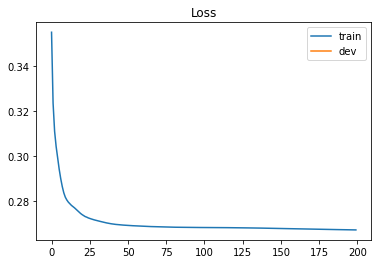

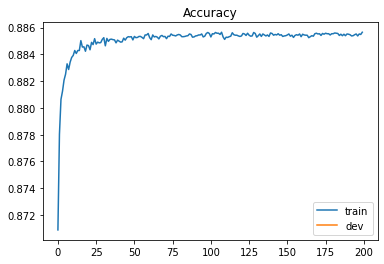

In [89]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

###Predicting testing labels

Predictions are saved to *output_logistic.csv*.

預測測試集的資料標籤並且存在 *output_logistic.csv* 中。

In [90]:
# Predict testing labels
predictions = _predict(X_test, w, b)
logi_pred_prob = _predict_prob(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Unemployed full-time 1.0842038693073446
 1 0.765957781959533
capital losses 0.6555767373989934
id 0.5755529534527281
 Other Rel <18 ever marr RP of subfamily -0.4813794230533009
 Grandchild 18+ ever marr RP of subfamily 0.4533617051095367
dividends from stocks -0.42162637437047545
 Householder -0.4173715605204303
 Grandchild <18 never marr not in subfamily 0.4143201221523154
 Nonfamily householder 0.37685507091627424


In [83]:
!gdown --id 1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 84.0kB/s]
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [91]:
!kaggle competitions submit -c ml2020spring-hw2 -f output_logistic.csv -m "Message"

100% 205k/205k [00:02<00:00, 104kB/s]
Successfully submitted to ML2020spring - hw2

# Porbabilistic generative model

In this section we will discuss a generative approach to binary classification. Again, we will not go through the formulation detailedly. Please find [Prof. Lee's lecture](https://www.youtube.com/watch?v=fZAZUYEeIMg) if you are interested in it.

接者我們將實作基於 generative model 的二元分類器，理論細節請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=fZAZUYEeIMg)。

### Preparing Data

Training and testing data is loaded and normalized as in logistic regression. However, since LDA is a deterministic algorithm, there is no need to build a development set.

訓練集與測試集的處理方法跟 logistic regression 一模一樣，然而因為 generative model 有可解析的最佳解，因此不必使用到 development set。

In [56]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### Mean and Covariance

In generative model, in-class mean and covariance are needed.

在 generative model 中，我們需要分別計算兩個類別內的資料平均與共變異。

In [78]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### Computing weights and bias

Directly compute weights and bias from in-class mean and shared variance. [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)(p.33) gives a concise explanation.

權重矩陣與偏差向量可以直接被計算出來，算法可以參考[李宏毅老師教學投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)第 33 頁。

In [79]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
gm_Y_train_pred_prob = 1 - _predict_prob(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8651537841262528


###Predicting testing labels

Predictions are saved to *output_generative.csv*.

預測測試集的資料標籤並且存在 *output_generative.csv* 中。

In [80]:
# Predict testing labels
predictions_gm = 1 - _predict(X_test, w, b)
gm_pred_prob = 1 - _predict_prob(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions_gm):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])


 Local government -8.17578125
 Wholesale trade 6.21282958984375
 40 -5.0924072265625
 Tennessee -3.97265625
 Education 3.673828125
 17 -3.353515625
 Medical except hospital 3.314453125
 0 -3.237457275390625
 32 -2.7861328125
 35 2.7421875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Emsemble two models

However, couldn't reach better result

In [85]:
pred_prob = (logi_pred_prob*0.5 + gm_pred_prob*0.5)
emsemble = (pred_prob > 0.5).astype(int)
with open(output_fpath.format('emsemble'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(emsemble):
        f.write('{},{}\n'.format(i, label))

In [86]:
!kaggle competitions submit -c ml2020spring-hw2 -f output_emsemble.csv -m "Message"

100% 205k/205k [00:02<00:00, 90.3kB/s]
Successfully submitted to ML2020spring - hw2